# Jump detection and classification example 1

This notebook shows the basic usage of the jump detection and classification routines. 

We start by loading the test data containing four Q3 light curves.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from time import time
from scipy.optimize import fmin
from scipy.ndimage import median_filter as mf
from scipy.ndimage import label
import scipy.ndimage as ndi

data = load('test_data.npz')
cadence = data['cadence']
fluxes  = data['flux']
flux_o  = fluxes[1,:].copy()
flux    = fluxes[1,:].copy()

The light curve already contains one real jump near cadence 7915, but let's add some additional ones to test the sensitivity of the routine. We also add a single large jump that we later ask to be ignored.

In [3]:
flux[cadence>8300]  *= 0.997
flux[cadence>9200]  *= 0.99
flux[cadence>9500]  *= 1.0025
flux[cadence>9900]  *= 1.0015
flux[cadence>11000] *= 1.0025

Let's also add two transit-like signals to the light curve for the fun of it: a deep one with a short duration, and a shallower one with a longer duration.

In [4]:
flux[(cadence>8600)&(cadence<8610)]  *= 0.995
flux[(cadence>11200)&(cadence<11215)]  *= 0.998

Jump search and classification
------------------------------

The most straightforward way to find the jumps is to call the ``find_jumps`` function with only the cadence and flux arrays as input parameters. 
Here we also set the a lower detection sigma limit than the default (10), and ask the routine to ignore anything between cadences 9100--9300. 

Jump search should be relatively fast, in order of milliseconds.

In [7]:
%run ../src/jfinder.py
jf = JumpFinder(cadence, flux)

In [9]:
%time jumps = jf.find_jumps()
print '\n', jumps

CPU times: user 18.8 s, sys: 34.3 s, total: 53.1 s
Wall time: 13.6 s
[Jump(7420.0, -0.0, None), Jump(7914.0, -0.0, None), Jump(8301.0, -0.0, None), Jump(8601.0, -0.0, None), Jump(8931.0, -0.0, None), Jump(9101.0, -0.0, None), Jump(9201.0, -0.0, None), Jump(9501.0,  0.0, None), Jump(9901.0,  0.0, None), Jump(9951.0, -0.0, None), Jump(10503.0, -0.0, None), Jump(11001.0,  0.0, None), Jump(11201.0, -0.0, None)]


In [29]:
%run ../src/jclassifier.py
jc = JumpClassifier(cadence, flux, jf.hp)

In [33]:
jc.classify(jumps)

In [15]:
[jc.classify(j) for j in jumps];

Next, we can classify the detected jumps, this will take slightly more time.

Plot the detected discontinuities
---------------------------------

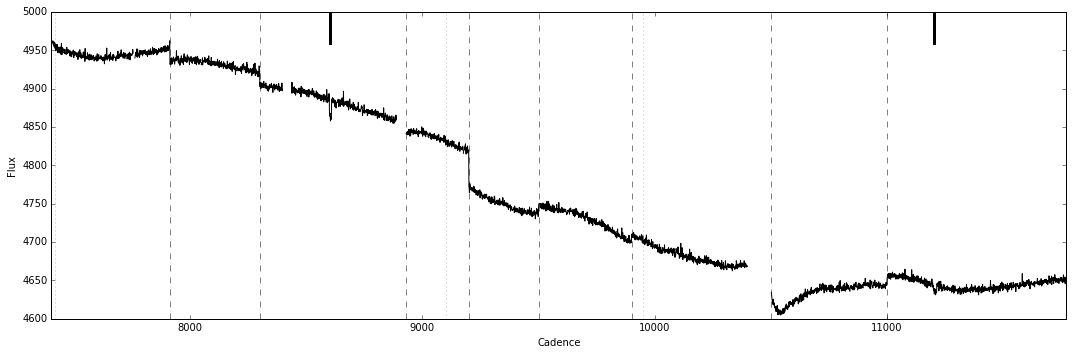

In [17]:
fig,ax = subplots(1,1,figsize=(15,5))
ax.plot(cadence, flux, 'k')
[ax.axvline(j.pos, ls=':', c='k', alpha=0.25) for j in jumps if j.type=='noise'] 
[ax.axvline(j.pos, ls='--', c='k', alpha=0.5) for j in jumps if j.type=='jump']
[ax.axvline(j.pos, 0.9, 1.0, c='k', lw=3)     for j in jumps if j.type=='transit']
[ax.axvline(j.pos, ls='-', c='k', alpha=0.5) for j in jumps if j.type=='flare']
setp(ax, xlim=cadence[[0,-1]], xlabel='Cadence', ylabel='Flux')
fig.tight_layout()

In [26]:
type(jumps[0])

core.Jump

In [25]:
isinstance(jumps[0], list)

False

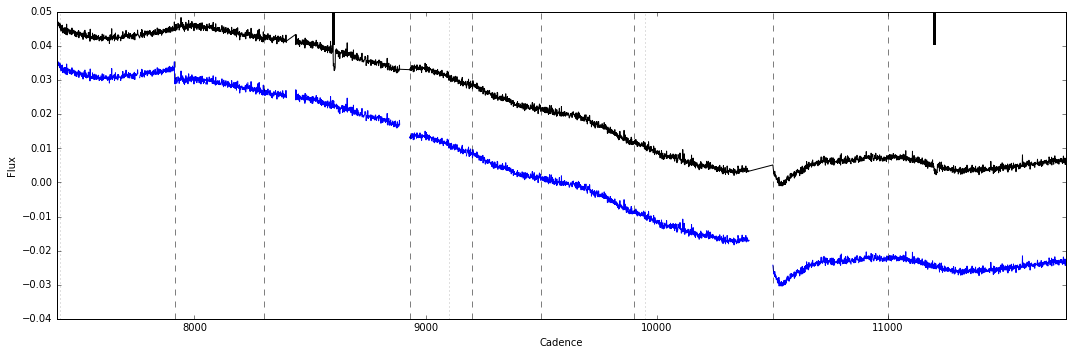

In [23]:
ff = jc.flux.copy()
for j in jumps:
    if j.type == 'jump':
        ff[jc.cadence >= j.pos] -= j.amp
        
fig,ax = subplots(1,1,figsize=(15,5))
ax.plot(jc.cadence, ff, 'k')
ax.plot(cadence, flux_o/nanmedian(flux_o)-1)
[ax.axvline(j.pos, ls=':', c='k', alpha=0.25) for j in jumps if j.type=='noise'] 
[ax.axvline(j.pos, ls='--', c='k', alpha=0.5) for j in jumps if j.type=='jump']
[ax.axvline(j.pos, 0.9, 1.0, c='k', lw=3)     for j in jumps if j.type=='transit']
[ax.axvline(j.pos, ls='-', c='k', alpha=0.5) for j in jumps if j.type=='flare']
setp(ax, xlim=cadence[[0,-1]], xlabel='Cadence', ylabel='Flux')
fig.tight_layout()